In [26]:
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alerts_antof, _ = utils.load_data('data.json')

alerts_antof = utils.separate_coords(alerts_antof)

accident = utils.extract_event(alerts_antof, 'ACCIDENT')
jam = utils.extract_event(alerts_antof, 'JAM')
hazard = utils.extract_event(alerts_antof, 'HAZARD')

hourly_accident = utils.hourly_group(accident)
hourly_jam = utils.hourly_group(jam)
hourly_hazard = utils.hourly_group(hazard)

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

linear_model = LinearRegression()

# Join the three DataFrames on the 'hour' index
dat = hourly_accident.join(hourly_jam, lsuffix='_accident', rsuffix='_jam').join(hourly_hazard, rsuffix='_hazard')

dat

day_type,Fin de semana_accident,Semana_accident,Fin de semana_jam,Semana_jam,Fin de semana,Semana
hour,,,,,,
0,1.0,6.0,1.0,1.0,5.0,5.0
1,NaN,2.0,2.0,9.0,12.0,1.0
2,0.0,0.0,NaN,2.0,12.0,1.0
3,0.0,0.0,2.0,NaN,2.0,3.0
4,1.0,NaN,1.0,NaN,4.0,NaN
5,4.0,NaN,NaN,1.0,4.0,1.0
6,2.0,2.0,NaN,4.0,5.0,7.0
7,2.0,25.0,1.0,539.0,10.0,47.0
8,2.0,26.0,5.0,367.0,4.0,54.0


In [28]:
dat = dat[['Semana_accident', 'Semana_jam']]

# Fill missing values with 0
dat = dat.fillna(0)

# Create the feature matrix X
X = dat[['Semana_jam']].values

# Create the target vector y
y = dat['Semana_accident'].values

y = hourly_accident.Semana.fillna(0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

y_pred

array([6.15357548, 7.02746894, 4.49777734, 8.13133437, 6.70550819])

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y_test, y_pred)
r2_score(y_test, y_pred)

print(f'Coeficiente de determinación: {r2_score(y_test, y_pred)}')
print(f'Error cuadrático medio: {mean_squared_error(y_test, y_pred)}')


Coeficiente de determinación: 0.15118298645703687
Error cuadrático medio: 22.612485240784537


In [30]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linear_model, X, y, cv=5)
print(f"R^2 scores: {scores}")

R^2 scores: [-3.50807598  0.87748296  0.12147372 -0.38183518  0.24986336]


In [31]:
import statsmodels.formula.api as smf

# Crear un DataFrame con los datos de entrenamiento
linear_model = smf.ols(data=dat, formula='Semana_accident ~ Semana_jam')
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Semana_accident   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     40.72
Date:                Thu, 12 Sep 2024   Prob (F-statistic):           2.02e-06
Time:                        22:01:55   Log-Likelihood:                -72.718
No. Observations:                  24   AIC:                             149.4
Df Residuals:                      22   BIC:                             151.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5095      1.312      3.437      0.0

In [32]:
results.params

Intercept     4.509484
Semana_jam    0.045668
dtype: float64

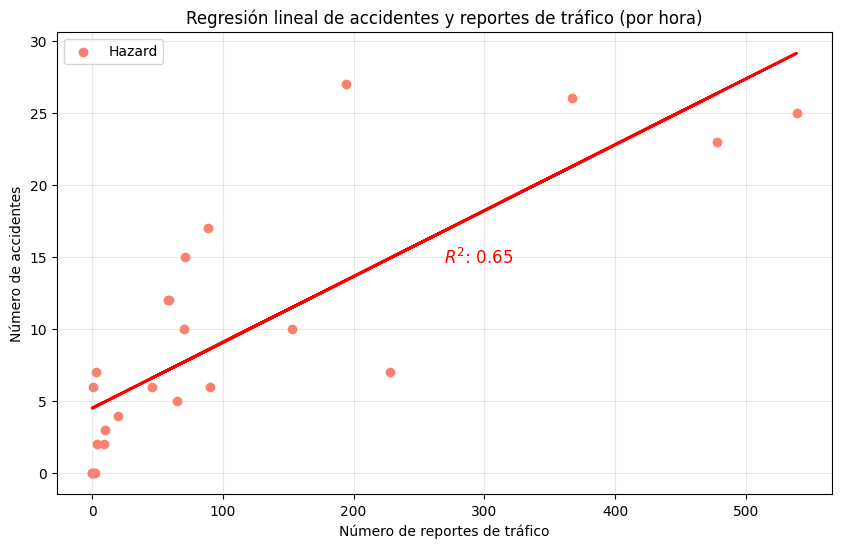

In [33]:
# Grafica la linea de regresión lineal de results y los datos originales

plt.figure(figsize=(10, 6))

# Graficar los datos originales
plt.scatter(dat['Semana_jam'], dat['Semana_accident'], color='salmon', label='Hazard')

# Graficar la línea de regresión
plt.plot(dat['Semana_jam'], results.params['Intercept'] + results.params['Semana_jam'] * dat['Semana_jam'], color='red', linewidth=2)

plt.title('Regresión lineal de accidentes y reportes de tráfico (por hora)')
plt.text(0.5, 0.5, rf'$R^2$: {results.rsquared:.2f}', transform=plt.gca().transAxes, fontsize=12,  color='red')
plt.xlabel('Número de reportes de tráfico')
plt.ylabel('Número de accidentes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [34]:
df_date = alerts_antof[['pubMillis', 'endreport', 'type']].copy()

In [39]:
df_date['pubMillis'] = df_date['pubMillis'] - 4 * 60 * 60 * 1000 # GMT-4

df_date['year'] = pd.to_datetime(df_date['pubMillis'], unit='ms').dt.year
df_date['month'] = pd.to_datetime(df_date['pubMillis'], unit='ms').dt.month
df_date['day'] = pd.to_datetime(df_date['pubMillis'], unit='ms').dt.day
df_date['hour'] = pd.to_datetime(df_date['pubMillis'], unit='ms').dt.hour

In [40]:
df_date.head()

,pubMillis,endreport,type,day,year,month,hour
0,1724345637000,1.724425e+12,HAZARD,22,2024,8,16
1,1724351878000,1.724425e+12,JAM,22,2024,8,18
2,1724353406000,1.724425e+12,JAM,22,2024,8,19
3,1724353622000,1.724425e+12,JAM,22,2024,8,19
4,1724353939000,1.724425e+12,ACCIDENT,22,2024,8,19
